# Домашнее задание 6: классификация текстов

В этом домашнем задании вам предстоит построить классификатор текстов!

Данные мы будем использовать из Kaggle соревнования: https://www.kaggle.com/competitions/nlp-getting-started/data 


Оттуда надо скачать файл train.csv. На обучающую и тестовую выборки его поделим кодом ниже, менять его не надо!

Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [1]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation as punc

In [2]:
data = pd.read_csv('train.csv')

In [3]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
from sklearn.model_selection import train_test_split

## Задание 1 (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [5]:
data.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [6]:
data = data.fillna('')

In [7]:
data.isna().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

## Задание 2 (1 балл)
Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Какое распределение классов в обучающей выборке?


In [8]:
data['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

#### выборка достаточно сбалансированная

2. Посмотрите на колонку "keyword" - возьмите 10 наиболее встречающихся значений, постройте ступенчатую диаграмму распределения классов в зависимости от значения keyword, сделайте выводы.

In [9]:
data['keyword'].value_counts().head(10)

               61
fatalities     45
deluge         42
armageddon     42
sinking        41
damage         41
harm           41
body%20bags    41
evacuate       40
fear           40
Name: keyword, dtype: int64

In [10]:
popular_keywords = data['keyword'].value_counts().iloc[1:12].index.values

Самый распространенный признак - NaN, а NaNом могло быть любое из ключевых слов, поэтому его не надо учитывать

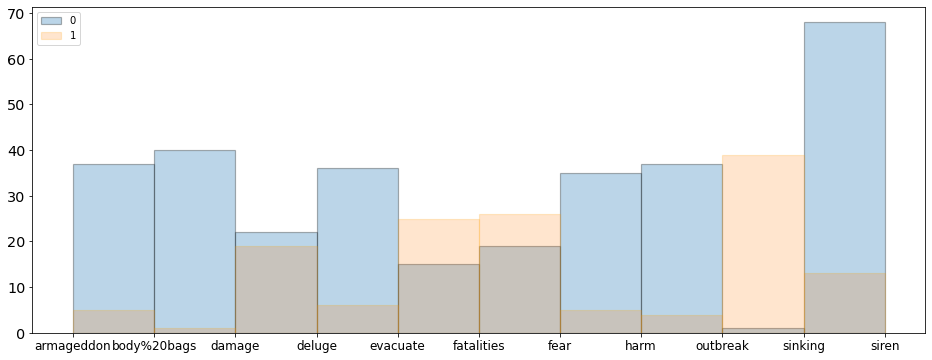

In [11]:
popular_data = data[(data["keyword"].isin(popular_keywords))]

plt.figure(figsize=(16, 6))

x1 = list(popular_data[popular_data['target'] == 1]['keyword'])
x2 = list(popular_data[popular_data['target'] == 0]['keyword'])
plt.hist([x2], density=False, histtype='bar', stacked=True, alpha=0.3, label = '0', edgecolor='black', linewidth=1.2)
plt.hist([x1], density=False, histtype='bar', stacked=True, alpha=0.2, label = '1', edgecolor='orange', linewidth=1.2)
plt.xticks(fontsize='large')
plt.yticks(fontsize='x-large')
plt.legend()
plt.show()

**Выводы**: в ключевых словах armageddon, body%20bags, deluge, fear, harm, sinking - сильно превалирует target '0',
а в outbreak - target '1'. В остальных нет такого сильно отрыва. 
Значит, данный признак важен в определении таргета.

## Задание 3 (0.5 балла) 

В этом задании предлагается объединить все три текстовых столбца в один (просто сконкатенировать cтроки) и убрать столбец с индексом.

In [13]:
data.loc[[6590, 7122, 2769]]

,id,keyword,location,text,target
6590,9436,survivors,"Marietta, GA",Stemming from my #Cubs talk- the team rosters ...,1
7122,10203,violent%20storm,,If you were the NWS wth a rotating storm w/ a ...,1
2769,3980,devastation,Atlanta g.a.,http://t.co/Gxgm1T3W0J From Devastation to Ela...,0


In [14]:
data_new = data.drop(['keyword', 'location', 'text', 'id'], axis=1)
data_new['text'] = data['keyword'] + data['location'] + data['text'] 

data_new.loc[[6590, 7122, 2769]]

,target,text
6590,1,"survivorsMarietta, GAStemming from my #Cubs ta..."
7122,1,violent%20stormIf you were the NWS wth a rotat...
2769,0,devastationAtlanta g.a.http://t.co/Gxgm1T3W0J ...


## Задание 4 (0.5 балла)

Далее мы будем пока работать только с train частью.

1. Предобработайте данные (train часть) с помощью CountVectorizer.
2. Какого размера получилась матрица?


In [15]:
from sklearn.feature_extraction.text import CountVectorizer

y = data_new['target']
x = data_new['text']
x_tr, x_t, y_tr, y_t = train_test_split(x, y, test_size=0.3, random_state=42)

cnt_vec = CountVectorizer()
m = cnt_vec.fit_transform(x_tr)
print('Размер матрицы: {} x {}'.format(m.shape[0], m.shape[1]))

Размер матрицы: 5329 x 22738


## Задание 5 (1 балл)

В предыдущем пункте у вас должна была получиться достаточно большая матрица.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов, ссылок и прочего мусора.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле vocabulary_ инстанса этого класса. Давайте напишем функцию, которая печает ответы на следующие вопросы:

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось?

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось? 

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре?

In [16]:
def contains_digit(s: str) -> bool:
    for sym in s :
        if sym >= '0' and sym <= '9' :
            return True
    return False

def contains_punctuation(s: str) -> bool:
    for sym in s :
        if sym in punc :
            return True
    return False

def is_hashtag(s: str) -> bool:
    if s[0] == '#' :
        return True
    return False

def is_mention(s: str) -> bool:
    if s[0] == '@' :
        return True
    return False

def investigate_vocabulary(vocabulary):
    print('With digit:      ', np.sum([1 for word in vocabulary.keys() if contains_digit(word)])
          )
    print('With punctuation:', np.sum([1 for word in vocabulary.keys() if contains_punctuation(word)])
          )
    print('Hashtags:        ', np.sum([1 for word in vocabulary.keys() if is_hashtag(word)])
          )
    print('Mentions:        ', np.sum([1 for word in vocabulary.keys() if is_mention(word)])
          )

In [17]:
dummy_vocab = {'th1nk' : 0,
               'think333' : 1,
               'think.' : 2,
               'th!nk' : 3,
               'th...nk' : 4,
               '#think' : 5,
               '@think' : 6,
               '@thinking':7,
               '@nothink' : 8,
               'think' : 9}
investigate_vocabulary(dummy_vocab)

With digit:       2
With punctuation: 7
Hashtags:         1
Mentions:         3


In [18]:
investigate_vocabulary(cnt_vec.vocabulary_)

With digit:       4590
With punctuation: 317
Hashtags:         0.0
Mentions:         0.0


## Задание 6 (0.5 балла)

Вспомним, что на семинаре по текстам мы узнали, что в nltk есть специальный токенизатор для текстов - TweetTokenizer. Попробуем применить CountVectorizer с этим токенизатором. Ответьте на все вопросы из предыдущего пункта для TweetTokenizer и сравните результаты.

In [19]:
from nltk.tokenize import TweetTokenizer

tt = TweetTokenizer()
x_tokenized = [' '.join(tt.tokenize(text)) for text in x_tr]

m = cnt_vec.fit_transform(x_tokenized)

In [20]:
investigate_vocabulary(cnt_vec.vocabulary_)

With digit:       4435
With punctuation: 316
Hashtags:         0.0
Mentions:         0.0


**Сравнение:** во втором случае нашлось меньше слов

## Задание 7 (2 балла)

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно: 

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
4. Проведет стемминг с помощью SnowballStemmer



In [21]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/elinaboldova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
import snowballstemmer
from nltk.corpus import stopwords

def contains_only_latin_letters(s: str) -> bool:
    for sym in s:
        if not ((sym >= 'a' and sym <= 'z') or (sym >= 'A' and sym <= 'Z')) :
            return False
    return True

def is_emoji(s: str) -> bool:
    brackets = '([{}])'
    counter = 0
    for sym in s:
        if sym not in punc:
            return False
        else :
            if sym in brackets:
                counter += 1
    if counter == 0 :
        return False
    else :
        return True


def is_hashtag(s: str) -> bool:
    if s[0] == '#' and contains_only_latin_letters(s[1:]) :
        return True
    return False

def custom_tokenizer(s: str) -> List[str]:   
    st = snowballstemmer.stemmer('english')
    
    ans = []
    token = tt.tokenize(s.lower())
    i = 0
    for word in token:
        if (is_hashtag(word) or contains_only_latin_letters(word)) and word != '' :
            res = st.stemWords(word.split())[0]
            if res not in stopwords.words('english') :
                ans.append(res)
        else :
            if is_emoji(word) and word != '' :
                ans.append(word)
    return ans
  

In [23]:
custom_tokenizer('She LOVES painting :-) #art')

['love', 'paint', ':-)', '#art']

Продемонстрируйте работу вашей функции на первых десяти текстах в обучающей выборке.

In [24]:
for i in range(10):
    print(custom_tokenizer(x_tr.iloc[i]))

['bridg', 'australia', 'collaps', 'trent', 'bridg', 'among', 'worst', 'histori', 'england', 'bundl', 'australia']
['hailcarol', 'stream', 'illinoisgreat', 'michigan', 'techniqu', 'camp', 'thank', '#goblu', '#wrestleon']
['policehouston', 'cnn', 'tennesse', 'movi', 'theater', 'shoot', 'suspect', 'kill', 'polic']
['riotingstil', 'riot', 'coupl', 'hour', 'left', 'class']
['woundslak', 'highlandscrack', 'path', 'wipe', 'morn', 'dure', 'beach', 'run', 'surfac', 'wound', 'left', 'elbow', 'right', 'knee']
['airplan', 'thereexpert', 'franc', 'begin', 'examin', 'airplan', 'debri', 'found', 'reunion', 'island', 'french', 'air', 'accid', 'expert', '#mlb']
['bloodyisol', 'citi', 'world', 'came', 'kill', 'indian', 'fun', 'video', 'smirk', 'remorseless', 'pakistani', 'killer', 'show', 'boast']
['burn', 'except', 'idk', 'realli', 'burn']
['destroyh', '(', 'ask', ')', 'destroy', 'hous']
['woundedmaracay', 'nirgua', 'venezuelapolic', 'offic', 'wound', 'suspect', 'dead', 'exchang', 'shot']


## Задание 8 (1 балл)

1. Примените CountVectorizer с реализованным выше токенизатором к обучающим и тестовым выборкам.


In [25]:
vectorizer = CountVectorizer(tokenizer = custom_tokenizer)
m = vectorizer.fit_transform(x_tr)
m_t = vectorizer.transform(x_t)

2. Обучите LogisticRegression на полученных признаках.


In [26]:
from sklearn.linear_model import LogisticRegression
    
clf = LogisticRegression(random_state=42)
clf.fit(m, y_tr)
y_pred = clf.predict(m_t)

3. Посчитайте метрику f1-score на тестовых данных.

In [27]:
from sklearn.metrics import f1_score

print('F1 score = {:.2f}'.format(f1_score(y_t, y_pred)))

F1 score = 0.74


## Задание 9 (1 балл)

1. Повторите 8 задание, но с tf-idf векторизатором. Как изменилось качество?


In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
    
tdf_vec = TfidfVectorizer(tokenizer = custom_tokenizer)
m = tdf_vec.fit_transform(x_tr)
m_t = tdf_vec.transform(x_t)

clf = LogisticRegression(random_state=42)
clf.fit(m, y_tr)
y_pred = clf.predict(m_t)

print('F1 score = {:.2f}'.format(f1_score(y_t, y_pred)))

F1 score = 0.73


In [29]:
m.shape

(5329, 13846)

1. **Ответ:** Качество классификации ухудшилось

2. Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?


In [30]:
tdf_vec = TfidfVectorizer(tokenizer = custom_tokenizer, max_df=0.9)
m = tdf_vec.fit_transform(x_tr)
m_t = tdf_vec.transform(x_t)

clf = LogisticRegression(random_state=42)
clf.fit(m, y_tr)
y_pred = clf.predict(m_t)

print('F1 score = {:.2f}'.format(f1_score(y_t, y_pred)))

F1 score = 0.73


In [31]:
m.shape

(5329, 13846)

2. **Ответ:** качество не изменилось, также как и размер матрицы, так как не нашлось слов с большей или равной долей.

3. Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df. Удалось ли добиться улучшения качества? 

In [32]:
tdf_vec = TfidfVectorizer(tokenizer = custom_tokenizer, min_df=2, max_df=0.9)
m = tdf_vec.fit_transform(x_tr)
m_t = tdf_vec.transform(x_t)

clf = LogisticRegression(random_state=42)
clf.fit(m, y_tr)
y_pred = clf.predict(m_t)

print('F1 score = {:.2f}'.format(f1_score(y_t, y_pred)))

F1 score = 0.73


In [33]:
m.shape

(5329, 4387)

3. **Ответ:** Качество классификатора ухудшилось по сравнению с запуском без TfidfVectorizer

## Задание 10 (1 балл)

Еще один популяпный трюк, который позволит уменьшить количество признаков называется hashing trick. Его суть в том, то мы случайно группируем признаки ииии  ..... складываем их! А потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Звучит странно, но это отлично работает. Давайте проверим этот трюк в нашем сеттинге.
Также при таком подходе вам не нужно хранить словарь token->index, что тоже иногда полезно.

1. Повторите задание 8 с HashingVectorizer, укажите количество фичей равное 5000.


In [34]:
from sklearn.feature_extraction.text import HashingVectorizer

hash_vec = HashingVectorizer(tokenizer = custom_tokenizer, n_features = 5000)
m = hash_vec.fit_transform(x_tr)
m_t = hash_vec.transform(x_t)

clf = LogisticRegression(random_state=42)
clf.fit(m, y_tr)
y_pred = clf.predict(m_t)

print('F1 score = {:.2f}'.format(f1_score(y_t, y_pred)))

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1 score = 0.71


In [35]:
from sklearn.feature_extraction.text import HashingVectorizer

hash_vec = HashingVectorizer(tokenizer = custom_tokenizer, n_features = 50000)
m = hash_vec.fit_transform(x_tr)
m_t = hash_vec.transform(x_t)

clf = LogisticRegression(random_state=42)
clf.fit(m, y_tr)
y_pred = clf.predict(m_t)

print('F1 score = {:.2f}'.format(f1_score(y_t, y_pred)))

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1 score = 0.73


2. Какой из подходов показал самый высокий результат?

**Ответ:** Наилучший результат вышел в результате применения CountVectorizer без TfidfVectorizer, а именно F1 score = 0.74

## Задание 11 (1 балл)

В этом задании нужно добиться f1 меры хотя в 0.75 на тестовых данных.

In [49]:
data = pd.read_csv('train.csv')

train, test = train_test_split(data, test_size=0.3, random_state=42)
train = train.dropna()

In [50]:
train_new = train.drop(['keyword', 'location', 'text', 'id'], axis=1)
train_new['text'] = train['keyword'] + train['location'] + train['text'] 

test_new = test.drop(['keyword', 'location', 'text', 'id'], axis=1)
test_new['text'] = test['keyword'] + test['location'] + test['text'] 

train_target = data_new['target']
train = data_new['text']

test_target = data_new['target']
test = data_new['text']

cnt_vec = CountVectorizer()
train = cnt_vec.fit_transform(train)

test = cnt_vec.transform(test)

In [53]:
clf = LogisticRegression(random_state=42, max_iter= 1e6)
clf.fit(train, train_target)
y_pred = clf.predict(test)

In [54]:
print('F1 score = {:.2f}'.format(f1_score(test_target, y_pred)))

F1 score = 0.98
